# 🧭 Assignment 6 Workflow: Knock Airport Weather Analysis

This notebook guides you through analysing hourly weather data from Knock Airport, using temperature trends. The dataset is sourced from [Met Éireann](https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv) and includes metadata that must be handled carefully.

## ✅ Workflow Summary

This notebook guides you through analysing hourly weather data from Knock Airport. The workflow includes:
- Inspecting the raw CSV structure
- Skipping metadata rows before the header
- Downloading and saving the file locally
- Loading and validating the dataset
- Plotting temperature and windspeed trends




### 📘 Step 0 – Inspect the Raw CSV File

Before loading the dataset, it's important to understand its structure. The Met Éireann CSV file contains metadata rows before the actual header, which can interfere with parsing.

You can inspect the file manually by downloading it from:  
🔗 https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv

Open it in a spreadsheet viewer or text editor and locate the row that begins with `"station"` — this marks the start of the actual data table.

Alternatively, preview the file programmatically:

```python
# Preview first 30 lines to locate the header
import requests
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"
response = requests.get(url)
print('\n'.join(response.text.splitlines()[:30]))
```

**📌 Why this matters:** Skipping metadata rows ensures the dataset loads correctly, avoids parsing errors, and improves reproducibility.



### 📦Step 1 Dependency Check
This cell verifies that optional interactive/rendering packages (`ipywidgets`, `jinja2`) are available.  
- The helper function `ensure_package` checks whether a package is installed.  
- If missing, it prints a commented `%pip install` line that reviewers can enable if needed.  
- This avoids repeated import errors and keeps the notebook reproducible across environments.  


In [1]:
# 📦 Confirm required packages are installed (avoids repeated import confirmations)
import importlib.util

def ensure_package(package_name, pip_name=None):
    """Check if a package is available; suggest pip install if missing."""
    if importlib.util.find_spec(package_name) is None:
        pip_name = pip_name or package_name
        print(f"📦 '{package_name}' not found. Uncomment the line below to install it:")
        print(f"# %pip install {pip_name}")
    else:
        print(f"✅ '{package_name}' is already installed.")

# 🔧 Interactivity and rendering (optional, for widgets/templates)
ensure_package("ipywidgets")
# %pip install ipywidgets   # Uncomment if not installed

ensure_package("jinja2")
# %pip install jinja2       # Uncomment if not installed


✅ 'ipywidgets' is already installed.
✅ 'jinja2' is already installed.


### 📚 Core Imports
This cell loads all required libraries for Assignment 06.  
- **Data handling:** `pandas`, `numpy`, `os`, `pathlib`, `requests`  
- **Date/time utilities:** `datetime`, `matplotlib.dates`  
- **Visualisation:** `matplotlib`, `seaborn`  
- **Interactivity/display:** `IPython.display`, `ipywidgets`  

Grouping imports by role makes the workflow transparent and easier to audit.  
All packages are pinned in `requirements.txt` to ensure reproducibility.  


In [2]:
# 📚 Core data and file handling
import pandas as pd           # Data manipulation
import numpy as np            # Numerical operations
import os                     # OS-level file handling
from pathlib import Path      # Object-oriented file paths
from io import StringIO       # In-memory text streams
import requests               # HTTP requests

# 📅 Date and time utilities
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.dates import WeekdayLocator, DateFormatter, MO

# 📊 Plotting and visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.table import Table

# 🧩 Notebook interactivity and display
from IPython.display import display, HTML
from ipywidgets import interact, widgets


### Step 3 Utilise Helper Functions for Weather Data Processing

This section defines a set of reusable helper functions that simplify common tasks throughout the notebook. These functions are designed to:

- ✅ Detect and parse inconsistent datetime formats
- ✅ Standardise and clean temperature columns
- ✅ Load and prepare weather data from local files
- ✅ Define Irish seasonal boundaries for analysis
- ✅ Filter data for a custom date range
- ✅ Validate user-provided date inputs

Each function is modular, meaning it performs one specific task and can be reused across different parts of the notebook. This improves readability, reduces duplication, and supports good programming practices.

📌 *Tip: These functions are written to be beginner-friendly and include comments to explain their purpose and logic.*

📖 Reference:  
- [Real Python – Python Helper Functions](https://realpython.com/defining-your-own-python-function/)  
- [GeeksforGeeks – Python Helper Functions](https://www.geeksforgeeks.org/python-helper-functions/)  
- [Wikipedia – DRY Principle (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)

In [3]:
# 📅 Detect the most likely datetime format from sample strings
def detect_datetime_format(samples, formats, dayfirst=True):
    """
    Tries each format in the list and returns the one that matches at least 70% of the samples.
    This helps ensure consistent parsing of date strings.
    """
    import pandas as pd
    for fmt in formats:
        parsed = pd.to_datetime(samples, format=fmt, dayfirst=dayfirst, errors='coerce')
        if parsed.notna().sum() >= max(1, int(len(samples) * 0.7)):
            return fmt
    return None

# 📅 Parse a datetime column using format detection or fallback
def parse_datetime_column(df, date_col, candidate_formats=None, dayfirst=True):
    """
    Attempts to parse a datetime column using a list of known formats.
    If no format matches, falls back to flexible parsing with pandas.
    """
    import pandas as pd
    import warnings

    if candidate_formats is None:
        candidate_formats = [
            '%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%d-%b-%Y %H:%M',
            '%d/%m/%Y %H:%M:%S', '%d/%m/%Y %H:%M', '%d-%m-%Y %H:%M',
            '%d %b %Y %H:%M', '%d %B %Y %H:%M',
        ]

    sample_vals = df[date_col].dropna().astype(str).head(80).tolist()
    chosen_fmt = detect_datetime_format(sample_vals, candidate_formats, dayfirst=dayfirst)

    if chosen_fmt:
        print(f"✅ Detected datetime format: {chosen_fmt}")
        return pd.to_datetime(df[date_col], format=chosen_fmt, dayfirst=dayfirst, errors='coerce')
    else:
        print("⚠️ No single format matched. Falling back to flexible parsing.")
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='Could not infer format')
            return pd.to_datetime(df[date_col], dayfirst=dayfirst, errors='coerce')

# 🌡️ Ensure temperature column is numeric and named 'temp'
def parse_temperature_column(df, col_name='temp'):
    """
    Converts the temperature column to numeric and renames it to 'temp' for consistency.
    If no exact match is found, searches for a column containing 'temp' in its name.
    """
    if col_name not in df.columns:
        col_name = next((c for c in df.columns if 'temp' in c.lower()), None)
        if col_name is None:
            raise KeyError("No temperature column found.")
    df['temp'] = pd.to_numeric(df[col_name], errors='coerce')
    return df

# 📂 Load cleaned weather data from local CSV
def load_cleaned_weather_data(filepath="data/assignment06_climate_data.csv"):
    """
    Loads the weather dataset from a local CSV file and strips any extra spaces from column names.
    """
    import pandas as pd
    from pathlib import Path

    filepath = str(filepath)  # ✅ Ensure compatibility with Path objects
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.strip()
    return df

# 🍂 Define Irish seasonal boundaries for a given year
def define_irish_seasons(year=2025):
    """
    Returns a DataFrame with start and end dates for each Irish season.
    Seasons follow the meteorological calendar.
    """
    import pandas as pd

    data = [
        ("Winter", pd.Timestamp(f"{year-1}-12-01 00:00"), pd.Timestamp(f"{year}-02-28 23:59")),
        ("Spring", pd.Timestamp(f"{year}-03-01 00:00"), pd.Timestamp(f"{year}-05-31 23:59")),
        ("Summer", pd.Timestamp(f"{year}-06-01 00:00"), pd.Timestamp(f"{year}-08-31 23:59")),
        ("Autumn", pd.Timestamp(f"{year}-09-01 00:00"), pd.Timestamp(f"{year}-11-30 23:59")),
    ]

    return pd.DataFrame(data, columns=["season", "start", "end"])

# 📊 Filter and prepare temperature data for a custom date range
def prepare_temperature_data(df, start_date, end_date, season_bounds=None):
    """
    Filters the weather data to a specific date range and extracts useful time features.
    Returns a cleaned DataFrame with datetime, date, and hour columns.
    """
    df = df.copy()
    df.columns = df.columns.str.strip()

    if 'date' not in df.columns:
        raise KeyError("Expected 'date' column not found in DataFrame.")

    # Parse datetime column with fallback
    try:
        df['datetime'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M', errors='raise')
    except Exception:
        df['datetime'] = pd.to_datetime(df['date'], errors='coerce')

    df = df.dropna(subset=['datetime'])

    # Filter by date range
    mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
    range_df = df.loc[mask].copy()

    # Extract date and hour for plotting
    range_df['date'] = range_df['datetime'].dt.date
    range_df['hour'] = range_df['datetime'].dt.strftime('%H:%M')

    return range_df.sort_values('datetime').reset_index(drop=True)

# 📆 Convert user input strings into a validated date range
def get_custom_range(start_str, end_str):
    """
    Converts string inputs into datetime objects and validates that the start is before the end.
    Returns a tuple of (start, end) or (None, None) if invalid.
    """
    try:
        start = pd.to_datetime(start_str)
        end = pd.to_datetime(end_str)
        if start > end:
            raise ValueError("Start date must be before end date.")
        return start, end
    except Exception as e:
        print(f"❌ Invalid date range: {e}")
        return None, None

# 🔍 Improved helper to detect the header row in a CSV file
def detect_header(lines):
    """
    Detects the most likely header row in a CSV file by scanning for structured column names.
    Prioritises lines starting with 'date' or 'station' and containing multiple comma-separated values.
    """
    for i, line in enumerate(lines):
        line_lower = line.strip().lower()
        if (line_lower.startswith("station") or line_lower.startswith("date")) and "," in line:
            columns = line.split(",")
            if len(columns) > 5:  # Heuristic: header rows usually have multiple columns
                return i

    # Fallback: return first line if no structured header is found
    print("⚠️ Warning: header row not found. Defaulting to first line.")
    return 0



### 🔍 Step 4 – Detect the Header Row in the Raw CSV

Before loading the dataset into pandas, we need to ensure we skip any metadata rows that appear before the actual header. Although we visually confirmed the header earlier, this step automates the process to make the notebook reproducible and robust.

The code below:
- Downloads the raw CSV file from Met Éireann
- Reads it line by line to locate the true header (usually the line starting with `"station"` or `"date,"`)
- Detects the index of the header row and prints it for confirmation

📌 *Why this matters:*  
Many climate datasets include metadata or notes before the actual data table. Programmatically detecting the header ensures we don’t hardcode assumptions about the file structure, which makes the notebook more reliable and adaptable to future datasets.

➡️ *The next step will use this header index to extract and save the cleaned data.*


In [4]:
# 📂 Step 4 – Download Raw CSV and Detect Header Row

# --- Define output path for cleaned CSV ---
DATA_PATH = Path("data/assignment06_climate_data.csv")

# --- Download raw CSV from Met Éireann ---
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"
response = requests.get(url)

# ✅ Check for successful response
if response.status_code != 200:
    raise RuntimeError(f"❌ Failed to download data: HTTP {response.status_code}")

# --- Split response into lines ---
lines = response.text.splitlines()

# --- Detect header row using helper function ---
header_index = detect_header(lines)

# ✅ Confirm detected header row
print(f"✅ Header row detected at line {header_index}:")
print(lines[header_index])


✅ Header row detected at line 23:
date,ind,rain,ind,temp,ind,wetb,dewpt,vappr,rhum,msl,ind,wdsp,ind,wddir,ww,w,sun,vis,clht,clamt


### 📁 Step 5 – Save the Cleaned CSV File

Now that we've detected the correct header row, we save a cleaned version of the dataset to the `data/` folder. This ensures:

- The file is stored locally for reuse without re-downloading
- All future analysis references a consistent, structured version of the data
- The workflow remains reproducible and version-controlled

📌 *Why this matters:* Saving cleaned data locally is a best practice in data science. It ensures consistency across runs and allows you to track changes over time.

Saving files locally supports reproducibility and version control in data science workflows [Explain Data Versioning](https://www.geeksforgeeks.org/machine-learning/explain-data-versioning/).

In [5]:
# 📁 Step 5 – Save the Cleaned CSV File

# --- Ensure 'data' folder exists ---
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# --- Save cleaned data starting from the detected header row ---
with open(DATA_PATH, "w", encoding="utf-8") as f:
    for line in lines[header_index:]:
        f.write(line + "\n")

# ✅ Confirm save location
print(f"📁 Saved cleaned climate data to: {DATA_PATH.resolve()}")


📁 Saved cleaned climate data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_climate_data.csv


### 📥 Step 6 – Load the Cleaned Dataset from Disk

Now that the cleaned CSV file has been saved locally (with metadata rows removed), we load it directly from disk using a helper function. This ensures:

- Consistent access to structured data
- Avoids repeated downloads or manual inspection
- Keeps the workflow reproducible and efficient

The helper function `load_cleaned_weather_data()` reads the file and strips any extra spaces from column names to ensure clean parsing.

📌 *Why this matters:* Loading from a local copy ensures that all analysis is based on a stable version of the dataset, which is essential for reproducibility and collaboration.



In [6]:
# 📥 Step 6 – Load the Cleaned Dataset from Disk

# --- Load the cleaned CSV using helper function ---
df = load_cleaned_weather_data()

# --- Preview the first few rows to confirm structure ---
df.head()


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,10-apr-1996 14:00,0,0.0,0,11.5,0,8.1,3.9,0.0,0,...,0,0,0,0,25,81,0.0,35000,32,5
1,31-jul-1996 08:00,0,0.0,0,11.5,0,11.1,10.7,0.0,0,...,0,0,0,0,25,82,0.0,40000,45,5
2,31-jul-1996 09:00,0,0.0,0,11.6,0,10.7,9.8,0.0,0,...,0,0,0,0,80,81,0.0,8000,32,7
3,31-jul-1996 10:00,0,0.0,0,12.9,0,11.3,9.8,0.0,0,...,0,0,0,0,25,82,0.0,28000,35,6
4,31-jul-1996 11:00,0,0.0,0,14.5,0,10.8,7.0,0.0,0,...,0,0,0,0,2,11,0.0,40000,40,6


### ✅ Step 7 – Validate the Dataset After Loading

Once the cleaned dataset has been loaded, it's important to confirm that the structure is correct and the data is usable. This validation step helps ensure that:

- Column names are correctly parsed
- Data types are appropriate for analysis
- Missing values are identified early
- The overall shape of the dataset is as expected

📌 *Why this matters:* Validating the dataset before analysis helps catch formatting issues, missing data, or unexpected column types that could affect downstream calculations or visualisations.



In [7]:
# ✅ Step 7 – Validate the Dataset After Loading

# --- Check column names ---
print("🧾 Column names:")
print(df.columns.tolist())

# --- Check data types ---
print("\n🔍 Data types:")
print(df.dtypes)

# --- Check for missing values ---
print("\n❓ Missing values per column:")
print(df.isnull().sum())

# --- Confirm overall shape of the dataset ---
print(f"\n📐 DataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")


🧾 Column names:
['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt']

🔍 Data types:
date      object
ind        int64
rain      object
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr    float64
rhum       int64
msl       object
ind.3      int64
wdsp      object
ind.4      int64
wddir     object
ww        object
w         object
sun      float64
vis       object
clht      object
clamt     object
dtype: object

❓ Missing values per column:
date     0
ind      0
rain     0
ind.1    0
temp     0
ind.2    0
wetb     0
dewpt    0
vappr    0
rhum     0
msl      0
ind.3    0
wdsp     0
ind.4    0
wddir    0
ww       0
w        0
sun      0
vis      0
clht     0
clamt    0
dtype: int64

📐 DataFrame shape: 257154 rows × 21 columns


## Article: Summer of 2025 becomes warmest season on record in Ireland

https://www.irishtimes.com/environment/2025/09/03/summer-of-2025-becomes-warmest-season-on-record-in-ireland/

> **Sustained heat**, especially at night, contributed to higher than normal average temperatures.  
>  
> This summer was **Ireland’s warmest season since records began in 1900**, according to provisional data from **Met Éireann**.  
>  
> **Met Éireann climatologist Paul Moore** said:  
> *“Ireland is experiencing the effects of climate change, and our climate projections show that our climate is going to become warmer.”*
>
> The hottest week of Summer 2025 in Ireland was July 10–16, with peak temperatures reaching 31°C on Saturday, July 12. This was part of a short-lived heatwave driven by the Azores High, affecting multiple stations including Knock Airport.  
>
> Knock Airport: Recorded 28.7°C — its highest July temperature on record
> https://www.breakingnews.ie/ireland/july-2025-was-9th-hottest-on-record-with-highest-temperature-of-31-degrees-1789636.html



### 🌦️ Step 8 – Define Meteorological Seasons in Ireland for 2025

Ireland’s meteorological seasons follow a fixed calendar pattern, as outlined by Met Éireann:

- **Winter**: 1 December (previous year) to 28 February  
- **Spring**: 1 March to 31 May  
- **Summer**: 1 June to 31 August  
- **Autumn**: 1 September to 30 November  

In this step, we use a helper function to define seasonal boundaries for 2025. These boundaries will later help us filter and analyse temperature data by season.

📌 *Reference:* [Met Éireann – Irish Seasons](https://www.met.ie/education/outreach-irish-seasons)


In [8]:
# 🌦️ Step 8 – Define Meteorological Seasons in Ireland for 2025

# --- Generate seasonal boundaries using helper function ---
seasons_2025 = define_irish_seasons()

# --- Display formatted season ranges ---
print("📅 Irish Seasons for 2025:")
for _, row in seasons_2025.iterrows():
    print(f"  {row['season']}: {row['start'].strftime('%d-%b-%Y %H:%M')} → {row['end'].strftime('%d-%b-%Y %H:%M')}")


📅 Irish Seasons for 2025:
  Winter: 01-Dec-2024 00:00 → 28-Feb-2025 23:59
  Spring: 01-Mar-2025 00:00 → 31-May-2025 23:59
  Summer: 01-Jun-2025 00:00 → 31-Aug-2025 23:59
  Autumn: 01-Sep-2025 00:00 → 30-Nov-2025 23:59


### 📆 Step 9 – Define and Validate a Custom Date Range

In this step, we focus on a specific period: **the hottest week of the year**, from **10–16 July 2025**. We use a helper function to define the date range and then check which Irish season it falls into.

This helps us:
- Customise the analysis to a meaningful time window
- Validate the input to avoid errors
- Align the range with seasonal boundaries for contextual insights

📌 *Why this matters:* Understanding which season a date range belongs to allows us to compare temperature patterns across seasons and ensure seasonal context is preserved in our analysis.


In [9]:
# 📆 Step 9 – Define and Validate a Custom Date Range

# --- Define custom date range using helper ---
custom_start, custom_end = get_custom_range("2025-07-10", "2025-07-16 23:59")

# --- Fallback to default if input is invalid ---
if custom_start is None or custom_end is None:
    print("⚠️ Invalid custom range returned by get_custom_range(); falling back to defaults.")
    custom_start = pd.Timestamp("2025-07-10")
    custom_end = pd.Timestamp("2025-07-16")

# --- Check which season the range falls into ---
matched_season = None
for _, row in seasons_2025.iterrows():
    if row["start"] <= custom_start <= row["end"] and row["start"] <= custom_end <= row["end"]:
        matched_season = row["season"]
        break

# --- Display season match result ---
if matched_season:
    print(f"📆 The custom range falls entirely within: {matched_season}")
else:
    print("⚠️ The custom range spans multiple seasons or falls outside defined bounds.")

# --- Prepare filtered temperature data for the selected range ---
range_df = prepare_temperature_data(df, custom_start, custom_end)


📆 The custom range falls entirely within: Summer


### 🧪 Step 10 – Load, Filter, and Prepare Temperature Data

This step prepares the weather dataset for time-series analysis by focusing on a specific date range. The process includes:

- ✅ Cleaning column names and identifying datetime and temperature columns
- ✅ Parsing datetime values using robust logic with fallback support
- ✅ Validating that the selected date range falls within a defined season
- ✅ Filtering the dataset to the selected range and extracting hourly temperature readings
- ✅ Creating a pivot table to visualise temperature by hour and date

📌 *Why this matters:* Clean and structured data is essential for accurate visualisation and analysis. This step ensures the dataset is ready for seasonal insights and temperature trend exploration.



In [10]:
# 🧪 Step 10 – Load, Filter, and Prepare Temperature Data

# --- Prepare filtered temperature data using helper ---
range_df = prepare_temperature_data(df, custom_start, custom_end)

if not range_df.empty:
    print(f"✅ Filtered data contains {len(range_df)} rows.")
    display(range_df.head())

    # --- Create pivot table: hourly temperature by date ---
    pivot = range_df.pivot(index='hour', columns='date', values='temp')

    # --- Reindex to include all dates in the selected range ---
    try:
        # Infer range from data if custom_start/custom_end are missing
        if custom_start is None or custom_end is None:
            inferred_start = pd.to_datetime(range_df['datetime'].min()).date()
            inferred_end = pd.to_datetime(range_df['datetime'].max()).date()
            print(f"ℹ️ Inferring range from data: {inferred_start} → {inferred_end}")
            start_date = inferred_start
            end_date = inferred_end
        else:
            # Accept pandas Timestamp or date-like objects
            start_date = custom_start.date() if hasattr(custom_start, "date") else pd.to_datetime(custom_start).date()
            end_date = custom_end.date() if hasattr(custom_end, "date") else pd.to_datetime(custom_end).date()

        full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        cols = [d.date() for d in full_dates]
        pivot = pivot.reindex(columns=cols)

    except Exception as e:
        print(f"❌ Error generating full date range: {e}")
        # Gracefully fallback to existing pivot
        pass

    # --- Display pivot table with formatting ---
    print(f"📊 Pivot table includes {len(pivot.columns)} days and {len(pivot.index)} hourly slots.")
    display(pivot.style.format("{:.1f}").background_gradient(cmap='YlOrRd', axis=None))

else:
    print("⚠️ No data found for the selected date range.")


✅ Filtered data contains 168 rows.


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,datetime,hour
0,2025-07-10,0,0.0,0,13.9,0,13.8,13.8,15.7,99,...,2,200,,,0.0,2000,1,8,2025-07-10 00:00:00,00:00
1,2025-07-10,3,0.0,0,13.7,0,13.7,13.7,15.7,100,...,2,190,,,0.0,300,2,8,2025-07-10 01:00:00,01:00
2,2025-07-10,0,0.0,0,13.6,0,13.6,13.6,15.6,100,...,2,190,,,0.0,4100,1,8,2025-07-10 02:00:00,02:00
3,2025-07-10,0,0.0,0,13.9,0,13.9,13.9,15.9,100,...,2,180,,,0.0,1200,1,8,2025-07-10 03:00:00,03:00
4,2025-07-10,0,0.0,0,14.0,0,14.0,14.0,16.0,100,...,2,180,,,0.0,1700,1,8,2025-07-10 04:00:00,04:00


📊 Pivot table includes 7 days and 24 hourly slots.


date,2025-07-10,2025-07-11,2025-07-12,2025-07-13,2025-07-14,2025-07-15,2025-07-16
hour,,,,,,,
00:00,13.9,15.5,15.2,19.2,15.5,12.3,11.3
01:00,13.7,14.8,14.7,18.2,15.7,12.8,10.6
02:00,13.6,14.5,15.0,17.2,14.6,12.7,10.2
03:00,13.9,13.5,14.4,16.9,13.6,12.5,10.2
04:00,14.0,12.8,14.3,16.6,13.3,12.5,10.5
05:00,14.0,13.3,13.5,16.6,13.3,12.3,9.6
06:00,14.3,14.1,15.0,17.8,13.1,12.3,11.6
07:00,15.8,15.9,16.7,18.7,13.5,12.6,12.7
08:00,17.0,16.9,19.3,20.5,12.1,13.6,14.0


### 📤 Step 11 – Save CSV and 📈 Plot Temperature Trends

This step saves the filtered temperature data to a local CSV file for future reference and generates a visual heatmap to show hourly temperature trends across the selected date range.

The process includes:
- Saving the filtered dataset to the `data/` folder
- Creating a pivot table of hourly temperatures by date
- Plotting the pivot table using a colour-coded heatmap
- Saving the visualisation to the `plots/` folder

📌 *Why this matters:* Saving outputs locally supports reproducibility and version control. Visualising temperature trends helps identify patterns, anomalies, and seasonal behaviours in the data.


✅ Saved filtered data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_temperature_range.csv


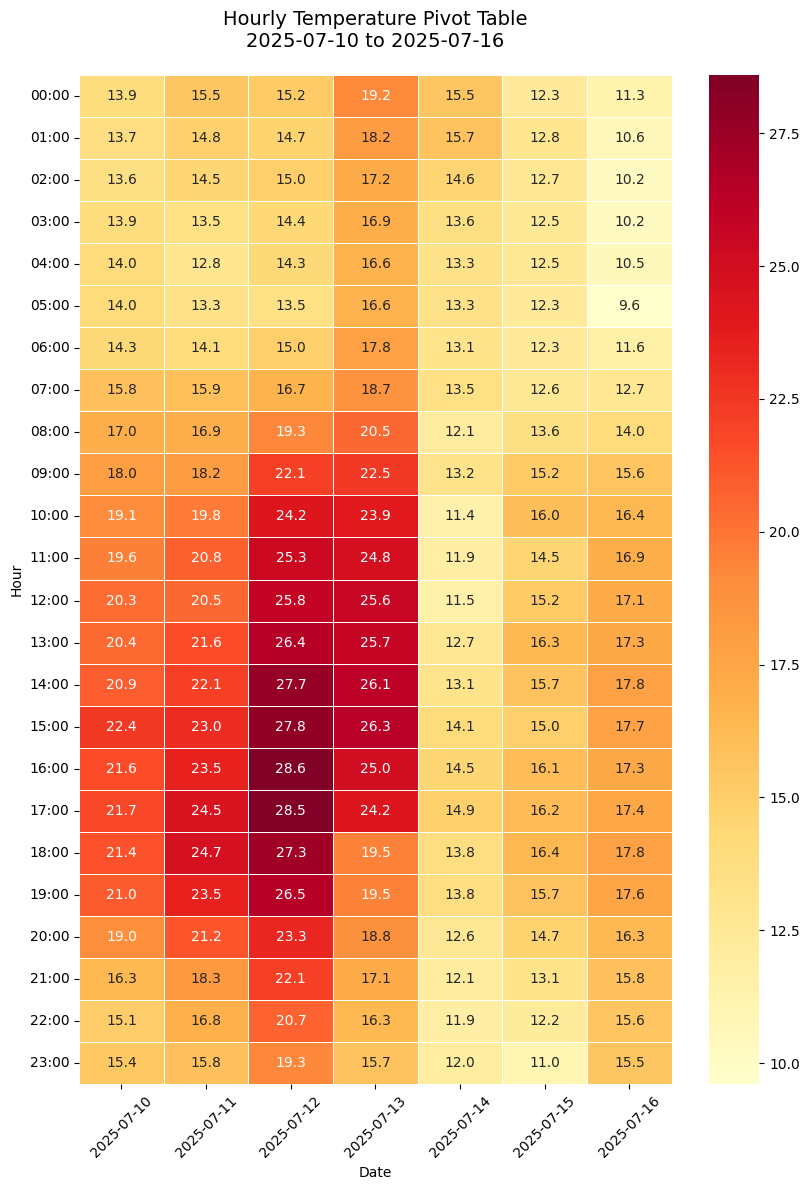

🖼️ Saved pivot table image to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_hourly_temperature_pivot_table_2025-07-10_to_2025-07-16.png


In [11]:
# 📤 Step 11 – Save CSV and 📈 Plot Temperature Trends

# --- Ensure output folders exist ---
Path("data").mkdir(parents=True, exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

# --- Save filtered temperature data to CSV ---
csv_path = Path("data") / "assignment06_temperature_range.csv"
range_df.to_csv(csv_path, index=False)
print(f"✅ Saved filtered data to: {csv_path.resolve()}")

# --- Create heatmap of hourly temperature trends ---
fig, ax = plt.subplots(figsize=(1.2 * len(pivot.columns), 0.5 * len(pivot.index)))

sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    ax=ax
)

# --- Add titles and labels ---
ax.set_title(f"Hourly Temperature Pivot Table\n{start_date} to {end_date}", fontsize=14, pad=20)
ax.set_xlabel("Date")
ax.set_ylabel("Hour")
plt.xticks(rotation=45)
plt.tight_layout()

# --- Save the plot to file ---
table_path = Path("plots") / f"assignment06_hourly_temperature_pivot_table_{start_date}_to_{end_date}.png"
plt.savefig(table_path, dpi=300)
plt.show()

print(f"🖼️ Saved pivot table image to: {table_path.resolve()}")



### 📈 Step 12 – Interactive Daily Temperature Plot with Hourly Ledger

This step creates an interactive visualisation of hourly temperature data for each day in the selected range (10–16 July 2025). It enables users to:

- Select a specific date using a slider widget
- View a line chart of hourly temperature readings for that day
- See annotations for each temperature point and a horizontal line showing the daily average
- Print a detailed ledger of hourly temperature values below the chart

The visualisation uses `ipywidgets` for interactivity and `matplotlib` for plotting. It also saves static daily plots to the `plots/` folder for future reference.

📌 *Why this matters:*  
This tool helps explore daily weather patterns, identify temperature spikes, and compare day-to-day variability — ideal for climate analysis and storytelling.



In [12]:
# 📈 Step 12 – Interactive Daily Temperature Plot with Hourly Ledger

# --- Prepare filtered temperature data using helper ---
range_df = prepare_temperature_data(df, custom_start, custom_end)

if not range_df.empty:
    print(f"✅ Filtered data contains {len(range_df)} rows.")
    display(range_df.head())

    # --- Create pivot table: hourly temperature by date ---
    pivot = range_df.pivot(index='hour', columns='date', values='temp')

    # --- Reindex to include all dates in the selected range ---
    try:
        if custom_start is None or custom_end is None:
            inferred_start = pd.to_datetime(range_df['datetime'].min()).date()
            inferred_end = pd.to_datetime(range_df['datetime'].max()).date()
            print(f"ℹ️ Inferring range from data: {inferred_start} → {inferred_end}")
            start_date = inferred_start
            end_date = inferred_end
        else:
            start_date = custom_start.date() if hasattr(custom_start, "date") else pd.to_datetime(custom_start).date()
            end_date = custom_end.date() if hasattr(custom_end, "date") else pd.to_datetime(custom_end).date()

        full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        cols = [d.date() for d in full_dates]
        pivot = pivot.reindex(columns=cols)

    except Exception as e:
        print(f"❌ Error generating full date range: {e}")
        pass

    print(f"📊 Pivot table includes {len(pivot.columns)} days and {len(pivot.index)} hourly slots.")

    # --- Ensure date column is in correct format ---
    if not pd.api.types.is_object_dtype(range_df['date']):
        range_df['date'] = pd.to_datetime(range_df['date']).dt.date

    date_list = sorted(range_df['date'].unique())

    # --- Save static daily plots (optional) ---
    save_plots = True
    plots_path = "plots"
    if save_plots:
        os.makedirs(plots_path, exist_ok=True)
        for selected_date in date_list:
            day_df = range_df[range_df['date'] == selected_date]
            if day_df.empty:
                continue

            avg_temp = day_df['temp'].mean()
            plt.figure(figsize=(12, 5))
            plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
            for x, y in zip(day_df['datetime'], day_df['temp']):
                plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
            plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
            plt.title(f"Hourly Temperature – {selected_date} (Knock Airport)")
            plt.xlabel("Date and Time")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.xticks(rotation=45)
            filename = os.path.join(plots_path, f"assignment06_hourly_temperature_{selected_date}.png")
            plt.savefig(filename, dpi=300)
            plt.close()

    # --- Define interactive plot function ---
    def plot_day(selected_date):
        day_df = range_df[range_df['date'] == selected_date]
        if day_df.empty:
            print(f"No data for {selected_date}")
            return

        avg_temp = day_df['temp'].mean()
        plt.figure(figsize=(12, 5))
        plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
        for x, y in zip(day_df['datetime'], day_df['temp']):
            plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
        plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
        plt.title(f"Hourly Temperature – {selected_date} (Knock Airport)")
        plt.xlabel("Date and Time")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        print(f"\n🧾 Hourly Ledger for {selected_date}:")
        print(day_df[['hour', 'temp']].round(1).to_string(index=False, justify='left', col_space=20))

    # --- Launch interactive widget ---
    print("\n📅 Interactive Daily Charts:")
    interact(plot_day, selected_date=widgets.SelectionSlider(
        options=date_list,
        value=date_list[0],
        description='Select Date',
        continuous_update=False
    ))

else:
    print("⚠️ No data found for the selected date range.")


✅ Filtered data contains 168 rows.


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,datetime,hour
0,2025-07-10,0,0.0,0,13.9,0,13.8,13.8,15.7,99,...,2,200,,,0.0,2000,1,8,2025-07-10 00:00:00,00:00
1,2025-07-10,3,0.0,0,13.7,0,13.7,13.7,15.7,100,...,2,190,,,0.0,300,2,8,2025-07-10 01:00:00,01:00
2,2025-07-10,0,0.0,0,13.6,0,13.6,13.6,15.6,100,...,2,190,,,0.0,4100,1,8,2025-07-10 02:00:00,02:00
3,2025-07-10,0,0.0,0,13.9,0,13.9,13.9,15.9,100,...,2,180,,,0.0,1200,1,8,2025-07-10 03:00:00,03:00
4,2025-07-10,0,0.0,0,14.0,0,14.0,14.0,16.0,100,...,2,180,,,0.0,1700,1,8,2025-07-10 04:00:00,04:00


📊 Pivot table includes 7 days and 24 hourly slots.

📅 Interactive Daily Charts:


interactive(children=(SelectionSlider(continuous_update=False, description='Select Date', options=(datetime.da…

### 📅 Step 13 – Manual Daily Temperature Plot with Hourly Ledger

This cell manually selects a specific date from the dataset and displays a static temperature plot along with a detailed hourly ledger. It is designed to work independently of any interactive widgets or upstream variables like `custom_start`.

🔧 Default behaviour:
- The date is manually set within the cell (currently: **12 July 2025**).
- You can change the date by editing the `input_date` variable directly.
- The cell validates the selected date and gracefully handles missing or invalid entries.

📌 *Why this matters:*  
Interactive widgets like sliders don’t render on GitHub, so this static display ensures that viewers can still see meaningful output when browsing the notebook online. It also provides a reliable fallback for environments where interactivity is limited.

💡 *Tip:* To explore other days, simply change the `input_date` value in the first line of the cell.



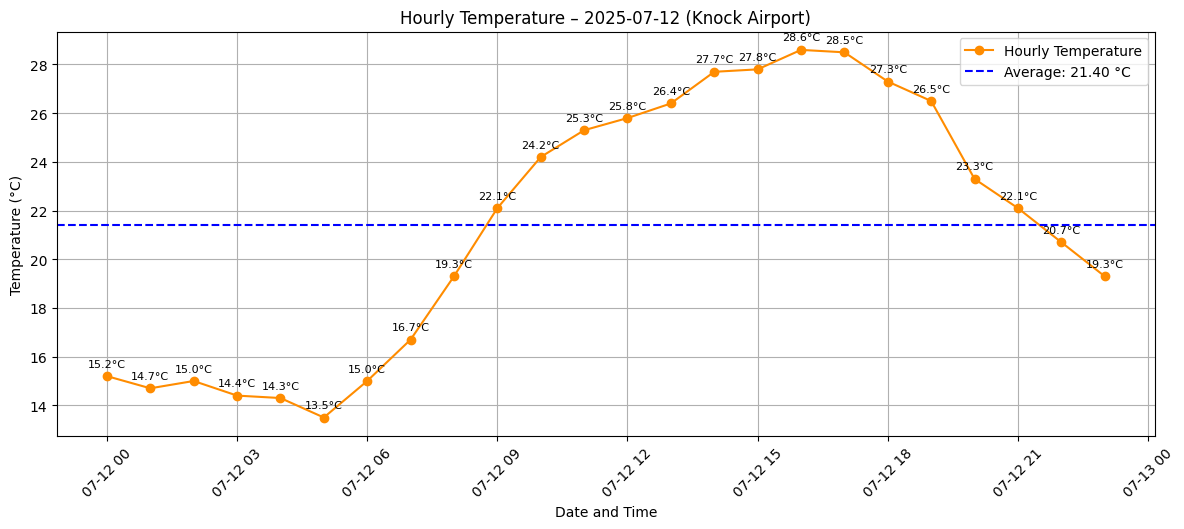


🧾 Hourly Ledger for 2025-07-12:
hour                  temp               
00:00                15.2                
01:00                14.7                
02:00                15.0                
03:00                14.4                
04:00                14.3                
05:00                13.5                
06:00                15.0                
07:00                16.7                
08:00                19.3                
09:00                22.1                
10:00                24.2                
11:00                25.3                
12:00                25.8                
13:00                26.4                
14:00                27.7                
15:00                27.8                
16:00                28.6                
17:00                28.5                
18:00                27.3                
19:00                26.5                
20:00                23.3                
21:00                22.1                
2

In [13]:
# 📌 Step 13 – Manual Daily Temperature Plot with Hourly Ledger

# --- Manually set the date to display ---
input_date = datetime(2025, 7, 12).date()  # 🔧 Change this to any date in your range

# --- Validate range_df before plotting ---
if 'range_df' not in globals() or range_df is None or range_df.empty:
    print("❌ No data available for the selected date range. Please check your previous steps.")
else:
    # --- Ensure date column is in correct format ---
    parsed_dates = pd.to_datetime(range_df['date'], errors='coerce').dt.date

    if input_date not in parsed_dates.unique():
        available = sorted(set(d for d in parsed_dates.dropna()))
        print(f"❌ Date {input_date} not found in dataset. Available dates: {available}")
    else:
        # --- Filter and plot for selected date ---
        mask = parsed_dates == input_date
        day_df = range_df.loc[mask].copy()

        if day_df.empty:
            print(f"❌ No hourly rows found for {input_date}.")
        else:
            avg_temp = day_df['temp'].mean()

            plt.figure(figsize=(12, 5))
            plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
            for x, y in zip(day_df['datetime'], day_df['temp']):
                plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
            plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
            plt.title(f"Hourly Temperature – {input_date} (Knock Airport)")
            plt.xlabel("Date and Time")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.xticks(rotation=45)
            plt.show()

            print(f"\n🧾 Hourly Ledger for {input_date}:")
            print(day_df[['hour', 'temp']].round(1).to_string(index=False, justify='left', col_space=20))


### 📊 Step 14 – Generate Mean Daily Temperature Summary for Summer 2025 (CSV Only)

This step calculates the **daily mean temperature** for **Summer 2025** using hourly climate data from Knock Airport. It includes:

- ✅ Parsing and cleaning datetime and temperature columns
- ✅ Filtering the dataset to the summer season (1 June to 31 August 2025)
- ✅ Computing daily statistics: count, mean, and standard deviation
- ✅ Saving the results to a tidy CSV file in the `data/` folder

📌 *Reference:* [Met Éireann – Irish Seasons](https://www.met.ie/education/outreach-irish-seasons)

This file can be reused for seasonal analysis, reporting, or visualisation. No plots are generated in this step — it focuses purely on data preparation and export.



In [14]:
# 📊 Step 14 – Generate Mean Daily Temperature Summary for Summer 2025 (CSV Only)

# --- Prerequisite Checks ---
if 'seasons_2025' not in globals():
    raise RuntimeError("Missing seasonal boundaries: 'seasons_2025' is not defined.")
if 'df' not in globals():
    raise RuntimeError("Missing dataset: 'df' is not defined.")

# --- Clean and parse datetime and temperature using helpers ---
df.columns = df.columns.str.strip()
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise RuntimeError("No date column found in the dataset.")

df['datetime'] = parse_datetime_column(df, date_col)  # from helpers
df = parse_temperature_column(df)  # from helpers

# --- Filter for Summer 2025 using seasonal bounds ---
summer_bounds = seasons_2025.loc[seasons_2025['season'].str.lower() == 'summer'].iloc[0]
start_date = pd.to_datetime(summer_bounds['start'])
end_date = pd.to_datetime(summer_bounds['end'])

summer_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
summer_df['date'] = summer_df['datetime'].dt.date

# --- Compute daily statistics ---
daily_stats = (
    summer_df.groupby('date')['temp']
    .agg(count='count', mean='mean', std='std')
    .reset_index()
)

daily_stats[['mean', 'std']] = daily_stats[['mean', 'std']].round(2)

# --- Save to CSV ---
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_climate_data_mean_daily_summer_2025.csv"
daily_stats.to_csv(out_fp, index=False)

# --- Display Output ---
print(f"✅ Saved daily temperature stats to: {out_fp}")
print("\n📋 First 20 rows of daily temperature summary:")
print(daily_stats.head(20).to_string(index=False))


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved daily temperature stats to: data\assignment06_climate_data_mean_daily_summer_2025.csv

📋 First 20 rows of daily temperature summary:
      date  count  mean  std
2025-06-01     24 11.19 1.85
2025-06-02     24 10.45 2.80
2025-06-03     24  9.40 1.49
2025-06-04     24 10.20 2.74
2025-06-05     24 10.28 2.00
2025-06-06     24 10.25 2.87
2025-06-07     24  9.56 1.75
2025-06-08     24 10.24 1.62
2025-06-09     24 11.61 1.48
2025-06-10     24 12.98 2.78
2025-06-11     24 14.40 2.32
2025-06-12     24 14.68 0.98
2025-06-13     24 15.23 1.64
2025-06-14     24 13.75 1.98
2025-06-15     24 13.90 2.13
2025-06-16     24 14.60 1.77
2025-06-17     24 14.92 1.94
2025-06-18     24 14.49 2.77
2025-06-19     24 17.59 5.35
2025-06-20     24 20.07 4.59


### 📈 Step 15 – Visualising Mean Temperatures for the Hottest Week of Summer 2025

This step loads the saved **daily mean temperature data** and visualises the hottest week of Summer 2025 — from **10 to 16 July**. According to [BreakingNews.ie](https://www.breakingnews.ie/), July 2025 ranked as the **9th hottest on record**, with temperatures peaking at **31°C**.

The process includes:
- Resolving the custom date range using a helper function
- Loading the daily mean temperature CSV
- Ensuring full date coverage for the selected range
- Plotting daily mean temperatures with annotations
- Saving the plot to the `plots/` folder
- Displaying a tidy ledger of daily values

📌 *Why this matters:*  
Visualising daily mean temperatures helps identify heatwaves, track seasonal extremes, and communicate climate trends effectively.


✅ Saved plot: plots\assignment06_mean_daily_custom_range.png


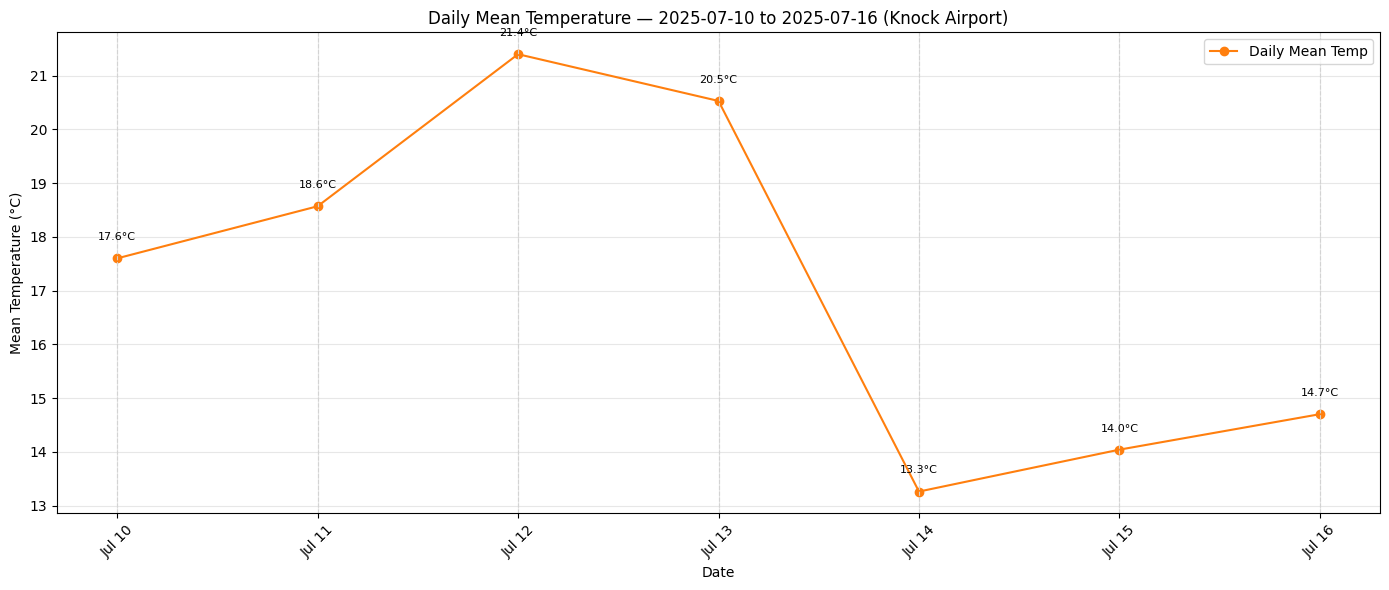


🧾 Daily Mean Ledger (2025-07-10 to 2025-07-16):
date                  mean               
2025-07-10           17.6                
2025-07-11           18.6                
2025-07-12           21.4                
2025-07-13           20.5                
2025-07-14           13.3                
2025-07-15           14.0                
2025-07-16           14.7                


In [15]:
# 📈 Step 15 – Visualising Mean Temperatures for the Hottest Week of Summer 2025

# --- Resolve custom_start and custom_end using helper ---
start_ts, end_ts = get_custom_range(custom_start, custom_end)

# --- Apply fallback if helper returns None ---
if start_ts is None or end_ts is None:
    start_ts = pd.Timestamp("2025-07-10")
    end_ts = pd.Timestamp("2025-07-16 23:59")

# --- Extract date components ---
start_date = start_ts.date()
end_date = end_ts.date()

# --- Load daily mean CSV ---
csv_fp = Path("data") / "assignment06_climate_data_mean_daily_summer_2025.csv"
if not csv_fp.exists():
    raise FileNotFoundError(f"Daily mean CSV not found at: {csv_fp.resolve()}")

daily_mean = pd.read_csv(csv_fp, parse_dates=['date'])

# --- Ensure full date coverage in custom range ---
full_dates = pd.date_range(start_date, end_date, freq='D')
full_df = pd.DataFrame({'date': full_dates})
custom_mean = full_df.merge(daily_mean, on='date', how='left')

# --- Plot if data is available ---
if custom_mean.empty or custom_mean['mean'].dropna().empty:
    print(f"⚠️ No data found between {start_date} and {end_date}.")
else:
    plt.figure(figsize=(14, 6))
    plt.plot(custom_mean['date'], custom_mean['mean'], marker='o', color='tab:orange', label='Daily Mean Temp')

    for x, y in zip(custom_mean['date'], custom_mean['mean']):
        if pd.notna(y):
            plt.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.8)
            plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)

    # --- Ensure 'date' is datetime64 and build tick labels safely ---
    dates = pd.to_datetime(custom_mean['date'], errors='coerce')
    labels = [d.strftime('%b %d') if not pd.isna(d) else '' for d in dates]

    plt.xticks(ticks=dates, labels=labels, rotation=45)
    plt.title(f'Daily Mean Temperature — {start_date} to {end_date} (Knock Airport)')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (°C)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # --- Save plot ---
    plots_dir = Path("plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    plot_fp = plots_dir / "assignment06_mean_daily_custom_range.png"
    plt.savefig(plot_fp, dpi=100)
    print(f'✅ Saved plot: {plot_fp}')
    plt.show()

    # --- Display daily mean ledger ---
    print(f"\n🧾 Daily Mean Ledger ({start_date} to {end_date}):")
    ledger = custom_mean[['date', 'mean']].copy()
    ledger['mean'] = ledger['mean'].round(1)
    print(ledger.to_string(index=False, justify='left', col_space=20))


### 📦 Step 16 – Monthly Mean Temperatures by Season (Winter, Spring, Summer & Autumn 2025)

This step calculates the **monthly mean temperature** for each month within the four meteorological seasons of 2025, based on Met Éireann’s seasonal definitions:

- **Winter**: December 2024 to February 2025  
- **Spring**: March to May 2025  
- **Summer**: June to August 2025  
- **Autumn**: September to November 2025

The process includes:
- Cleaning and parsing datetime and temperature columns
- Filtering the dataset by seasonal boundaries
- Grouping by month and calculating count, mean, and standard deviation
- Saving the results to a tidy CSV file for further analysis

📁 Output:
- CSV: `data/assignment06_monthly_mean_by_season_2025.csv`  
- PNG plot: `plots/assignment06_monthly_mean_by_season_2025.png` *(generated in Part 2)*

📌 *Why this matters:*  
Monthly summaries help identify seasonal trends, compare inter-month variability, and support climate reporting and visualisation.


In [16]:
# 📊 Step 16 – Monthly Temperature Summary by Season (2025)

# ✅ Ensure prerequisites
if 'seasons_2025' not in globals():
    raise RuntimeError("Missing seasonal boundaries: 'seasons_2025' is not defined.")
if 'df' not in globals():
    raise RuntimeError("Missing dataset: 'df' is not defined.")

# 🧼 Clean and parse datetime and temperature using helpers
df.columns = df.columns.str.strip()
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise RuntimeError("❌ No date-like column found in dataset.")

df['datetime'] = parse_datetime_column(df, date_col)
df = parse_temperature_column(df)

# 📅 Seasons to analyse (in desired order)
seasons_of_interest = ['Winter', 'Spring', 'Summer', 'Autumn']
rows = []

for season in seasons_of_interest:
    season_row = seasons_2025.loc[seasons_2025['season'].str.lower() == season.lower()]
    if season_row.empty:
        print(f"⚠️ Season '{season}' not found in seasons_2025; skipping.")
        continue

    bounds = season_row.iloc[0]
    start = pd.to_datetime(bounds['start'])
    end = pd.to_datetime(bounds['end'])

    mask = (df['datetime'] >= start) & (df['datetime'] <= end)
    sub = df.loc[mask].dropna(subset=['datetime', 'temp']).copy()

    if sub.empty:
        print(f"⚠️ No data for {season} between {start.date()} and {end.date()}")
        continue

    # Convert to monthly periods to group by calendar month
    sub['month'] = sub['datetime'].dt.to_period('M').dt.to_timestamp()
    monthly = sub.groupby('month')['temp'].agg(count='count', mean='mean', std='std').reset_index()
    monthly['season'] = season
    rows.append(monthly)

# 📁 Save and display results
if not rows:
    print("⚠️ No monthly data computed for the selected seasons.")
else:
    monthly_df = pd.concat(rows, ignore_index=True)

    # Enforce seasonal order
    seasonal_order = pd.CategoricalDtype(categories=seasons_of_interest, ordered=True)
    monthly_df['season'] = monthly_df['season'].astype(seasonal_order)

    monthly_df = monthly_df.sort_values(['season', 'month']).reset_index(drop=True)
    monthly_df[['mean', 'std']] = monthly_df[['mean', 'std']].round(2)

    # Optional: reorder columns for readability
    monthly_df = monthly_df[['season', 'month', 'count', 'mean', 'std']]

    # Save to CSV
    out_dir = Path("data")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_fp = out_dir / "assignment06_monthly_mean_by_season_2025.csv"
    monthly_df.to_csv(out_fp, index=False)

    print(f"✅ Saved monthly means CSV: {out_fp}")

    # Display summary
    print("\n📋 Monthly summary by season:")
    try:
        display(monthly_df)
    except Exception:
        print(monthly_df.to_string(index=False))


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved monthly means CSV: data\assignment06_monthly_mean_by_season_2025.csv

📋 Monthly summary by season:


,season,month,count,mean,std
0,Winter,2024-12-01,744,6.38,3.02
1,Winter,2025-01-01,744,3.78,3.40
2,Winter,2025-02-01,672,5.06,2.70
3,Spring,2025-03-01,744,7.21,2.88
4,Spring,2025-04-01,720,9.80,4.02
5,Spring,2025-05-01,744,12.41,3.86
6,Summer,2025-06-01,720,13.43,3.41
7,Summer,2025-07-01,744,15.07,3.10
8,Summer,2025-08-01,744,15.18,2.91
9,Autumn,2025-09-01,720,11.37,2.62


### 📈 Step 17 – Plot Monthly Mean Temperatures by Season (Winter, Spring, Summer 2025)

This step visualises the **monthly mean temperatures** calculated for Winter, Spring, and Summer 2025. It generates a **line plot** to illustrate temperature trends across these seasons, highlighting seasonal variations and monthly patterns.

The plot:
- Connects monthly mean temperatures with markers for each season
- Uses colour-coded lines to distinguish seasons
- Is saved to the `plots/` folder for reporting or reuse

📌 *Why this matters:*  
Visualising monthly temperatures helps reveal seasonal transitions, detect anomalies, and communicate climate trends effectively.


✅ Saved plot: plots\assignment06_monthly_mean_by_season_2025.png


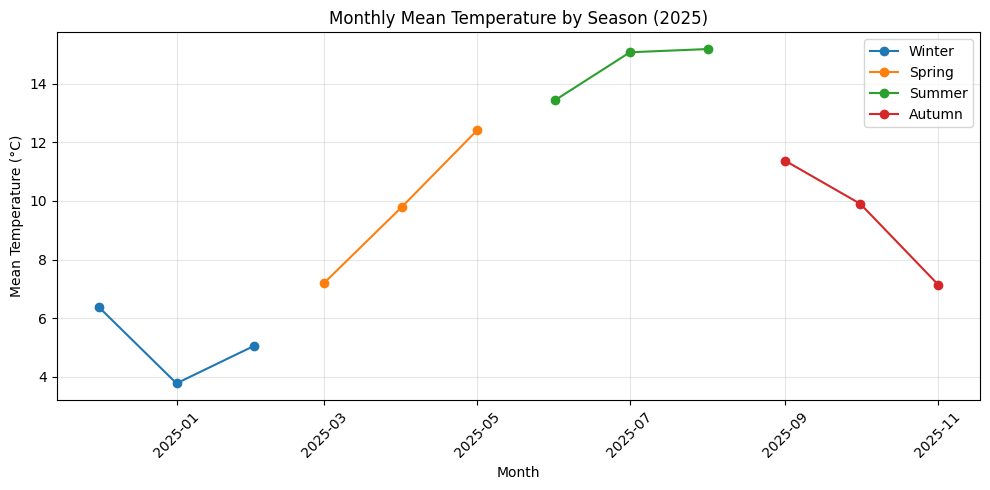

In [17]:
# 📈 Step 17 – Plot Monthly Mean Temperatures by Season (Winter, Spring, Summer 2025)

# --- Create line plot of monthly mean temperatures ---
plt.figure(figsize=(10, 5))

for s in seasons_of_interest:
    sub = monthly_df[monthly_df['season'] == s]
    if sub.empty:
        continue
    plt.plot(sub['month'], sub['mean'], marker='o', label=s)

# --- Add titles and labels ---
plt.title('Monthly Mean Temperature by Season (2025)')
plt.xlabel('Month')
plt.ylabel('Mean Temperature (°C)')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# --- Save plot to file ---
plots_dir = Path('plots')
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / 'assignment06_monthly_mean_by_season_2025.png'
plt.savefig(plot_fp, dpi=150)
print(f'✅ Saved plot: {plot_fp}')
plt.show()


### 🌬️ Step 18 – Windspeed Data Analysis for Summer 2025

This step analyses the **windspeed data** from the Knock Airport weather dataset, focusing on the **Summer 2025** season. It includes:

- Loading the cleaned climate dataset
- Parsing datetime and windspeed columns
- Filtering the data to the summer season (June–August 2025)
- Saving the cleaned windspeed subset to a CSV file

The output file is stored in the `data/` folder and can be used for further analysis or visualisation of wind patterns at Knock Airport.

📌 *Why this matters:*  
Windspeed trends are essential for understanding local weather dynamics, aviation safety, and renewable energy potential.


In [18]:
# 🌬️ Step 18 – Clean Windspeed Data for Summer 2025

# ✅ Load cleaned weather data using helper
data_fp = Path("data") / "assignment06_climate_data.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Climate data file not found at: {data_fp.resolve()}")

df = load_cleaned_weather_data(str(data_fp))  # from helpers

# ✅ Parse datetime using helper
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise KeyError("❌ No date column found in dataset.")
df['datetime'] = parse_datetime_column(df, date_col)  # from helpers

# ✅ Parse windspeed column
if 'wdsp' not in df.columns:
    raise KeyError("❌ Missing 'wdsp' column for windspeed.")
df['windspeed'] = pd.to_numeric(df['wdsp'], errors='coerce')

# ✅ Ensure seasonal boundaries are available
seasons_2025 = globals().get('seasons_2025')
if seasons_2025 is None:
    seasons_2025 = define_irish_seasons(2025)  # from helpers

summer_row = seasons_2025.loc[seasons_2025['season'].str.lower() == 'summer']
if summer_row.empty:
    raise RuntimeError("❌ Summer season not found in seasons_2025.")

start = pd.to_datetime(summer_row.iloc[0]['start'])
end = pd.to_datetime(summer_row.iloc[0]['end'])

# ✅ Filter and clean summer windspeed data
summer_df = df[(df['datetime'] >= start) & (df['datetime'] <= end)].copy()
summer_df = summer_df.dropna(subset=['windspeed'])

# 💾 Save to CSV
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_windspeed_cleaned_summer_2025.csv"
summer_df.to_csv(out_fp, index=False)

print(f"✅ Saved cleaned windspeed data for Summer 2025: {out_fp.resolve()}")


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved cleaned windspeed data for Summer 2025: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_windspeed_cleaned_summer_2025.csv


### 🌬️ Step 19 – Windspeed Cleaning, Missing Data Handling & Hourly Analysis (10–16 July 2025)

This step prepares and analyses **windspeed data** from Knock Airport during the heatwave period of **10–16 July 2025**, aligning with the earlier temperature analysis.

#### 🧼 Cleaning and Missing Data Handling
- Extracts the `wdsp` column (hourly mean windspeed in knots)
- Converts values to numeric using `pd.to_numeric(..., errors='coerce')`
- Removes rows with missing or invalid windspeed values

This ensures that only valid observations are used in the analysis, following best practice in data science. According to [W3Schools](https://www.w3schools.com/python/pandas/pandas_cleaning.asp), removing missing values before summarising data helps maintain integrity and avoid misleading results.

#### 📊 Windspeed Analysis (10–16 July 2025)
- Filters cleaned data to the custom date range
- Creates a pivot table of hourly windspeed across each day
- Visualises daily windspeed trends to identify patterns or anomalies
- Saves both the pivot table and the plot for future reference

📁 Outputs:
- CSV: `data/assignment06_windspeed_hourly_table_2025-07-10_to_2025-07-16.csv`
- PNG: `plots/assignment06_windspeed_hourly_2025-07-10_to_2025-07-16.png`


✅ Saved hourly windspeed table: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_windspeed_hourly_table_2025-07-10_to_2025-07-16.csv
✅ Saved plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_windspeed_hourly_2025-07-10_to_2025-07-16.png


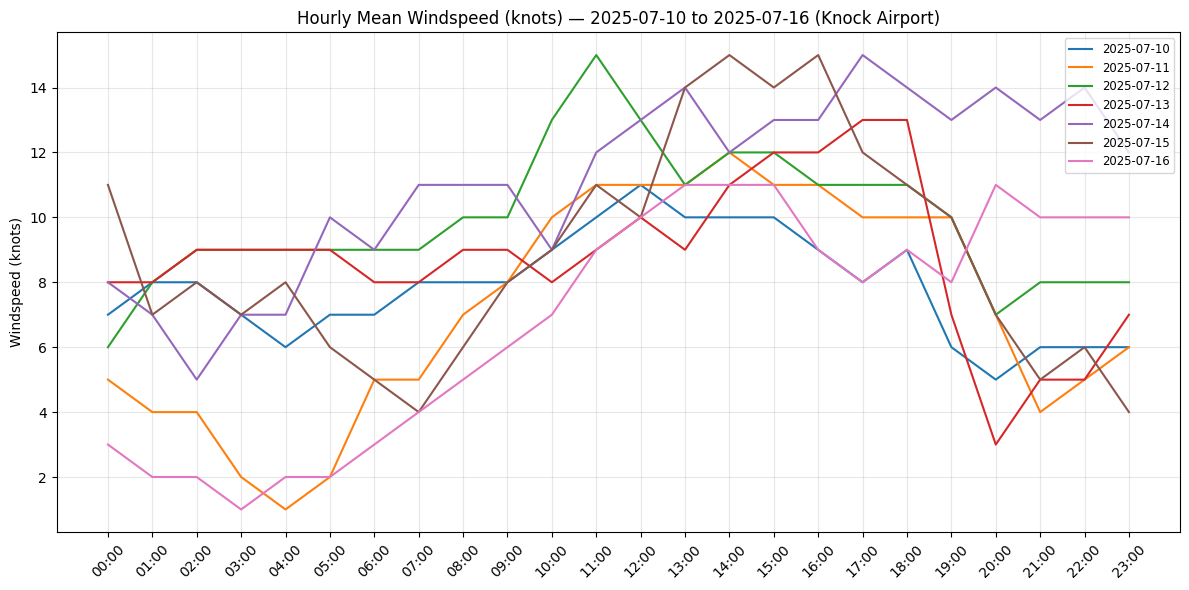


📋 Hourly Mean Windspeed Table:


date,2025-07-10,2025-07-11,2025-07-12,2025-07-13,2025-07-14,2025-07-15,2025-07-16
hour,,,,,,,
00:00,7.0,5.0,6.0,8.0,8.0,11.0,3.0
01:00,8.0,4.0,8.0,8.0,7.0,7.0,2.0
02:00,8.0,4.0,9.0,9.0,5.0,8.0,2.0
03:00,7.0,2.0,9.0,9.0,7.0,7.0,1.0
04:00,6.0,1.0,9.0,9.0,7.0,8.0,2.0
05:00,7.0,2.0,9.0,9.0,10.0,6.0,2.0
06:00,7.0,5.0,9.0,8.0,9.0,5.0,3.0
07:00,8.0,5.0,9.0,8.0,11.0,4.0,4.0
08:00,8.0,7.0,10.0,9.0,11.0,6.0,5.0


In [19]:
# 🌬️ Step 19 – Hourly Windspeed Trends for Custom Date Range (10–16 July 2025)

# ✅ Load cleaned windspeed data
data_fp = Path("data") / "assignment06_windspeed_cleaned_summer_2025.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Windspeed data file not found at: {data_fp.resolve()}")

df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()

# ✅ Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# ✅ Resolve custom_start and custom_end using helper
if 'custom_start' not in globals() or 'custom_end' not in globals():
    raise RuntimeError("❌ custom_start and custom_end must be defined.")

start_ts, end_ts = get_custom_range(custom_start, custom_end)
if start_ts is None or end_ts is None:
    print("⚠️ Invalid custom date range — using fallback range.")
    start_ts = pd.Timestamp("2025-07-10")
    end_ts = pd.Timestamp("2025-07-16 23:59")

# ✅ Ensure datetime-like timestamps and safe date extraction
try:
    start_ts = pd.to_datetime(start_ts)
    end_ts = pd.to_datetime(end_ts)
except Exception as e:
    raise RuntimeError(f"❌ Failed to convert custom range to timestamps: {e}")

start_date = start_ts.date() if hasattr(start_ts, "date") else pd.to_datetime(start_ts).date()
end_date = end_ts.date() if hasattr(end_ts, "date") else pd.to_datetime(end_ts).date()

# 📆 Filter data for selected range
focus_df = df[(df['datetime'] >= start_ts) & (df['datetime'] <= end_ts)].copy()
focus_df = focus_df.dropna(subset=['windspeed'])

# ✅ Ensure output directories exist before use
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)

# ✅ Safe date/hour extraction
focus_df['date'] = pd.to_datetime(focus_df['datetime'], errors='coerce').dt.date
focus_df['hour'] = pd.to_datetime(focus_df['datetime'], errors='coerce').dt.strftime('%H:%M')

# 📊 Create pivot table: hourly windspeed across selected dates
pivot = focus_df.pivot_table(index='hour', columns='date', values='windspeed', aggfunc='mean')

# 💾 Save pivot table
pivot_fp = out_dir / f"assignment06_windspeed_hourly_table_{start_ts.date()}_to_{end_ts.date()}.csv"
pivot.to_csv(pivot_fp)
print(f"✅ Saved hourly windspeed table: {pivot_fp.resolve()}")

# 📈 Plot hourly windspeed trends
plt.figure(figsize=(12, 6))
for date in pivot.columns:
    plt.plot(pivot.index, pivot[date], label=str(date))

plt.title(f"Hourly Mean Windspeed (knots) — {start_ts.date()} to {end_ts.date()} (Knock Airport)")
plt.ylabel("Windspeed (knots)")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Save plot
plot_fp = plots_dir / f"assignment06_windspeed_hourly_{start_ts.date()}_to_{end_ts.date()}.png"
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved plot: {plot_fp.resolve()}")
plt.show()

# 📋 Display pivot table
print("\n📋 Hourly Mean Windspeed Table:")
try:
    display(pivot)
except Exception:
    print(pivot.to_string(index=True))


### 🌬️ Step 20 – Rolling Windspeed (24-Hour Average) for 10–16 July 2025

This step calculates a **24-hour rolling average** of windspeed data from Knock Airport, smoothing short-term fluctuations and highlighting longer-term wind behaviour. The analysis spans **10–16 July 2025**, aligning with previous temperature and windspeed studies.

Key actions:
- Load cleaned windspeed data
- Filter for the target date range
- Compute a 24-hour rolling mean using hourly data
- Plot the smoothed windspeed trend across the week
- Save both the plot and the summary data for future reference

📌 *Why this matters:*  
Rolling averages help reveal sustained wind patterns, making them ideal for aviation, energy, and climate analysis.


✅ Saved rolling windspeed plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_windspeed_rolling_24hr_2025-07-10_to_2025-07-16.png


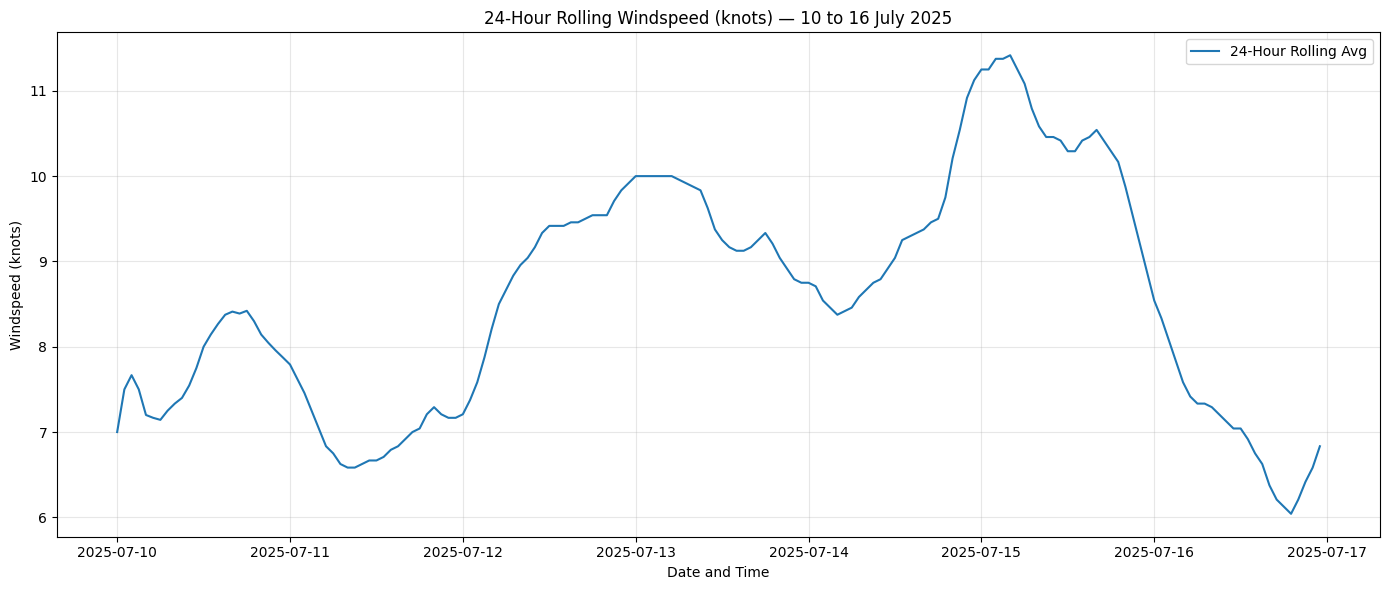

✅ Saved rolling windspeed data: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_windspeed_rolling_24hr_2025-07-10_to_2025-07-16.csv


In [20]:
# 🌬️ Step 20 – Rolling Windspeed (24-Hour Average) for 10–16 July 2025

# ✅ Load cleaned windspeed data
data_fp = Path("data") / "assignment06_windspeed_cleaned_summer_2025.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Windspeed data file not found at: {data_fp.resolve()}")

df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()

# ✅ Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# ✅ Filter for 10–16 July 2025
start_ts = pd.Timestamp("2025-07-10 00:00")
end_ts = pd.Timestamp("2025-07-16 23:59")
focus_df = df[(df['datetime'] >= start_ts) & (df['datetime'] <= end_ts)].copy()
focus_df = focus_df.dropna(subset=['windspeed'])

# ✅ Sort and compute 24-hour rolling average
focus_df = focus_df.sort_values('datetime')
focus_df['rolling_24hr'] = focus_df['windspeed'].rolling(window=24, min_periods=1).mean()

# 📈 Plot rolling average
plt.figure(figsize=(14, 6))
plt.plot(focus_df['datetime'], focus_df['rolling_24hr'], color='tab:blue', label='24-Hour Rolling Avg')
plt.title('24-Hour Rolling Windspeed (knots) — 10 to 16 July 2025')
plt.xlabel('Date and Time')
plt.ylabel('Windspeed (knots)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# 💾 Save plot
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / "assignment06_windspeed_rolling_24hr_2025-07-10_to_2025-07-16.png"
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved rolling windspeed plot: {plot_fp.resolve()}")
plt.show()

# 💾 Save summary data
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_windspeed_rolling_24hr_2025-07-10_to_2025-07-16.csv"
focus_df[['datetime', 'windspeed', 'rolling_24hr']].to_csv(out_fp, index=False)
print(f"✅ Saved rolling windspeed data: {out_fp.resolve()}")


### 🌬️ Step 21 – Daily Max Windspeed Summary (10–16 July 2025)

This step identifies the **maximum windspeed** recorded each day during the heatwave period of **10–16 July 2025** at Knock Airport. For each day, it extracts:

- The highest windspeed value
- The exact time it occurred
- A tidy summary table for reporting and analysis

The output is saved to a CSV file in the `data/` folder and displayed in the notebook.

📌 *Why this matters:*  
Daily peak windspeed values are useful for assessing weather extremes, aviation safety, and energy forecasting. Capturing the time of peak windspeed adds valuable context for operational planning.


In [21]:
# 🌬️ Step 21 – Daily Max Windspeed Summary (10–16 July 2025)

# ✅ Load cleaned windspeed data
data_fp = Path("data") / "assignment06_windspeed_cleaned_summer_2025.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Windspeed data file not found at: {data_fp.resolve()}")

df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()

# ✅ Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# ✅ Ensure windspeed column exists and is numeric
if 'windspeed' not in df.columns and 'wdsp' in df.columns:
    df['windspeed'] = pd.to_numeric(df['wdsp'], errors='coerce')
else:
    df['windspeed'] = pd.to_numeric(df['windspeed'], errors='coerce')

# 📆 Define focus week: 10–16 July 2025
start_ts = pd.Timestamp("2025-07-10 00:00")
end_ts = pd.Timestamp("2025-07-16 23:59")

# 📊 Filter and compute daily max windspeed and time
week_df = df[(df['datetime'] >= start_ts) & (df['datetime'] <= end_ts)].copy()
week_df = week_df.dropna(subset=['windspeed'])

# ✅ Derive a safe date column (pure date objects) from datetime
week_df['date'] = pd.to_datetime(week_df['datetime'], errors='coerce').dt.date

# ✅ Find max windspeed and time for each day (robust to missing values)
# Sort by windspeed descending, then keep the first occurrence per day
week_df = week_df.sort_values(['date', 'windspeed'], ascending=[True, False])
daily_max_rows = (
    week_df.dropna(subset=['date'])
    .drop_duplicates(subset=['date'], keep='first')
    .sort_values('date')
    .reset_index(drop=True)
)

# ✅ Format output
daily_max_rows['windspeed'] = daily_max_rows['windspeed'].round(2)
daily_max_rows['time_of_max'] = daily_max_rows['datetime'].apply(
    lambda ts: ts.strftime('%H:%M') if not pd.isna(ts) else ''
)

# ✅ Select and rename columns
daily_max_summary = daily_max_rows[['date', 'windspeed', 'time_of_max']]
daily_max_summary.columns = ['date', 'max_windspeed', 'time_of_max']

# 💾 Save results
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_daily_max_windspeed_with_time_10_16_July_2025.csv"
daily_max_summary.to_csv(out_fp, index=False)

# 📋 Display results
print(f"✅ Saved daily max windspeed summary with time: {out_fp.resolve()}")
print("\n📈 Daily Max Windspeed and Time (10–16 July 2025):")
try:
    display(daily_max_summary)
except Exception:
    print(daily_max_summary.to_string(index=False))


✅ Saved daily max windspeed summary with time: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_daily_max_windspeed_with_time_10_16_July_2025.csv

📈 Daily Max Windspeed and Time (10–16 July 2025):


,date,max_windspeed,time_of_max
0,2025-07-10,11.0,12:00
1,2025-07-11,12.0,14:00
2,2025-07-12,15.0,11:00
3,2025-07-13,13.0,17:00
4,2025-07-14,15.0,17:00
5,2025-07-15,15.0,14:00
6,2025-07-16,11.0,13:00


### 📊 Step 22 – Plot Daily Max Windspeed with Time (10–16 July 2025)

This step visualises the **daily maximum windspeed** recorded at Knock Airport during the heatwave period of **10–16 July 2025**. Each point on the line plot shows:

- The peak windspeed for the day (in knots)
- The exact time it occurred (annotated below each point)

The plot helps identify wind extremes and their timing, providing valuable context for weather analysis, aviation safety, and operational planning.

📁 Output:
- PNG: `plots/assignment06_daily_max_windspeed_line_10_16_July_2025.png`

**💡 Why this matters:**

Understanding when peak wind events occur during a heatwave can reveal important atmospheric dynamics. High winds during extreme heat can:

- Exacerbate fire risk and spread
- Impact aircraft operations and flight safety
- Influence energy demand and grid stability
- Affect outdoor events, agriculture, and public safety

By pinpointing both the magnitude and timing of wind peaks, this plot supports more informed decision-making across weather-sensitive sectors.

[WHO – Climate Crisis: Extreme Weather](https://www.who.int/news-room/fact-sheets/detail/climate-crisis-extreme-weather)

✅ Saved line plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_daily_max_windspeed_line_10_16_July_2025.png


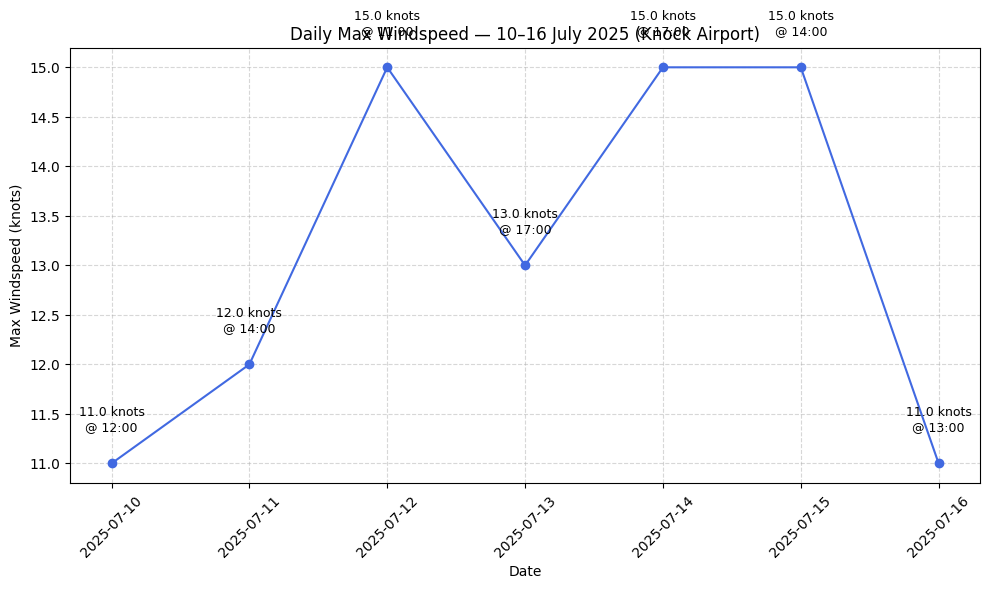

In [22]:
# 📊 Step 22 – Line Plot of Daily Max Windspeed (10–16 July 2025)

# ✅ Load saved summary
summary_fp = Path("data") / "assignment06_daily_max_windspeed_with_time_10_16_July_2025.csv"
if not summary_fp.exists():
    raise FileNotFoundError(f"❌ Summary file not found at: {summary_fp.resolve()}")

df = pd.read_csv(summary_fp)
df.columns = df.columns.str.strip()

# 🔢 Sort by date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

# 🎨 Create line plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['max_windspeed'], marker='o', linestyle='-', color='royalblue')

# 🕒 Annotate each point with windspeed and time
for x, y, time in zip(df['date'], df['max_windspeed'], df['time_of_max']):
    plt.text(x, y + 0.3, f"{y} knots\n@ {time}", ha='center', va='bottom', fontsize=9)

plt.title("Daily Max Windspeed — 10–16 July 2025 (Knock Airport)")
plt.xlabel("Date")
plt.ylabel("Max Windspeed (knots)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Save plot
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / "assignment06_daily_max_windspeed_line_10_16_July_2025.png"
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved line plot: {plot_fp.resolve()}")
plt.show()


### 🌬️ Step 23 – Monthly Mean of Daily Max Windspeeds (July 2025)

This step calculates the **monthly mean** of **daily maximum windspeed** values recorded at Knock Airport during **July 2025**. It includes:

- Filtering the cleaned dataset to the full month of July
- Computing the maximum windspeed for each day
- Calculating the monthly mean of these daily peaks
- Saving both the daily and monthly summaries to CSV files

📁 Outputs:
- Daily max windspeed: `data/assignment06_daily_max_windspeed_July_2025.csv`
- Monthly mean of daily max: `data/assignment06_monthly_mean_of_daily_max_windspeed_July_2025.csv`

📌 *Why this matters:*  
This summary helps identify how consistently strong winds were across the month, offering insights into weather extremes, aviation planning, and energy forecasting.


In [23]:
# 🌬️ Step 23 – Daily Max Windspeed and Monthly Mean — July 2025

# ✅ Load cleaned windspeed data
data_fp = Path("data") / "assignment06_windspeed_cleaned_summer_2025.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Windspeed data file not found at: {data_fp.resolve()}")

df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()

# ✅ Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 📆 Filter for July 2025
july_start = pd.Timestamp("2025-07-01 00:00")
july_end = pd.Timestamp("2025-07-31 23:59")
july_df = df[(df['datetime'] >= july_start) & (df['datetime'] <= july_end)].copy()
july_df = july_df.dropna(subset=['windspeed'])

# 🗓️ Extract date for daily grouping
# Ensure 'datetime' is parsed and then extract pure date objects using bracket access
july_df['date'] = pd.to_datetime(july_df['datetime'], errors='coerce').dt.date

# 📊 Compute daily max windspeed
# Use bracket access and ensure types are correct to avoid attribute access errors
daily_max = (
    july_df
    .dropna(subset=['date', 'windspeed'])
    .groupby('date', as_index=False)['windspeed']
    .max()
)
daily_max['windspeed'] = pd.to_numeric(daily_max['windspeed'], errors='coerce').round(2)

# 📈 Compute monthly mean of daily max values
monthly_mean = round(daily_max['windspeed'].mean(), 2)

# 💾 Save daily max and monthly mean to CSV
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
daily_fp = out_dir / "assignment06_daily_max_windspeed_July_2025.csv"
summary_fp = out_dir / "assignment06_monthly_mean_of_daily_max_windspeed_July_2025.csv"

daily_max.to_csv(daily_fp, index=False)
pd.DataFrame([{'month': 'July 2025', 'mean_daily_max_windspeed': monthly_mean}]).to_csv(summary_fp, index=False)

# 📋 Display results
print(f"✅ Saved daily max windspeed: {daily_fp.resolve()}")
print(f"✅ Saved monthly mean of daily max windspeed: {summary_fp.resolve()}")
print(f"\n📈 Monthly Mean of Daily Max Windspeed (July 2025): {monthly_mean} knots")


✅ Saved daily max windspeed: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_daily_max_windspeed_July_2025.csv
✅ Saved monthly mean of daily max windspeed: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_monthly_mean_of_daily_max_windspeed_July_2025.csv

📈 Monthly Mean of Daily Max Windspeed (July 2025): 12.68 knots


### 🌬️ Step 24 – Plot Daily Max Windspeed with Monthly Mean (July 2025)

This step visualises the **daily maximum windspeed** recorded at Knock Airport throughout **July 2025**, and overlays the **monthly mean** of those daily peaks.

The plot includes:
- A line connecting daily max windspeed values
- A horizontal dashed line showing the monthly mean
- Annotations for each day’s peak windspeed

📌 *Why this matters:*  
This visual helps identify wind extremes, assess variability across the month, and compare individual days against the monthly average.

📁 Output:
- PNG: `plots/assignment06_daily_max_windspeed_with_monthly_mean_July_2025.png`


✅ Saved plot with monthly mean line: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_daily_max_windspeed_with_monthly_mean_July_2025.png


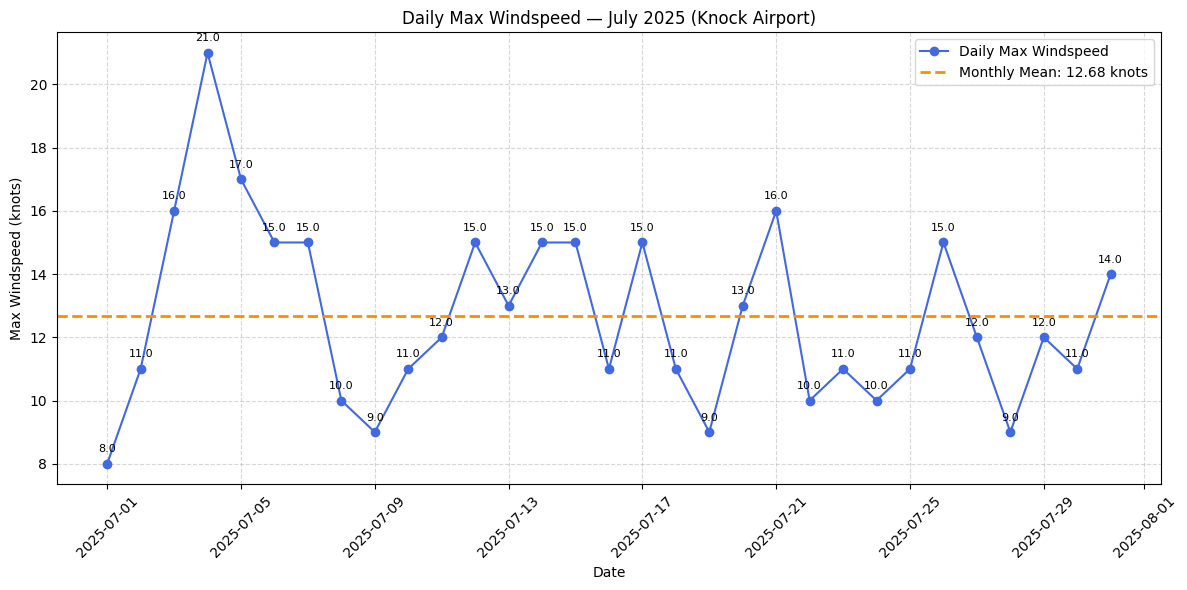

In [24]:
# 🌬️ Step 24 – Daily Max Windspeed Line Plot with Monthly Mean — July 2025

# ✅ Load daily max windspeed data
daily_fp = Path("data") / "assignment06_daily_max_windspeed_July_2025.csv"
if not daily_fp.exists():
    raise FileNotFoundError(f"❌ Daily max windspeed file not found at: {daily_fp.resolve()}")

df = pd.read_csv(daily_fp)
df.columns = df.columns.str.strip()

# 🧼 Ensure date column is parsed
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

# 📈 Calculate monthly mean of daily max windspeed
monthly_mean = round(df['windspeed'].mean(), 2)

# 🎨 Create line plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['windspeed'], marker='o', linestyle='-', color='royalblue', label='Daily Max Windspeed')
plt.axhline(monthly_mean, color='darkorange', linestyle='--', linewidth=2, label=f'Monthly Mean: {monthly_mean} knots')

# 🕒 Annotate each point with value
for x, y in zip(df['date'], df['windspeed']):
    plt.text(x, y + 0.3, f"{y}", ha='center', va='bottom', fontsize=8)

plt.title("Daily Max Windspeed — July 2025 (Knock Airport)")
plt.xlabel("Date")
plt.ylabel("Max Windspeed (knots)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 💾 Save plot
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / "assignment06_daily_max_windspeed_with_monthly_mean_July_2025.png"
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved plot with monthly mean line: {plot_fp.resolve()}")
plt.show()
